This notebook imports, cleans, and performs exploratory data analysis on data to be used in the Orthopedic Feature Modeling project.  A supervised classification machine learning project that predicts the results of Abnormal vs Normal radiology results for the determinination of slipped vertebra - Spondylolisthesis.

#### Import libraries

In [22]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder   # Encode target
from scipy.stats import gamma, poisson, norm, t, ttest_ind
#from numpy.random import seed
from scipy import stats

#### Load data - we see 310 records, no null values, 6 interger features and a string target "class"


In [23]:
data = pd.read_csv('Data/weka2c.csv')         # import 1 file
data.info()
print(data["class"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB
Abnormal    210
Normal      100
Name: class, dtype: int64


#### Rename columns for simplicity

In [24]:
data = data.rename(columns = {'pelvic_incidence':'incidence', 'pelvic_tilt numeric': 'tilt',
                           'lumbar_lordosis_angle': 'angle', 'sacral_slope': 'slope',
                           'pelvic_radius': 'radius', 'degree_spondylolisthesis' : 'degree',
                            'class':'class'}).dropna()

### EDA

#### Pie chart of data balance

<AxesSubplot:ylabel='class'>

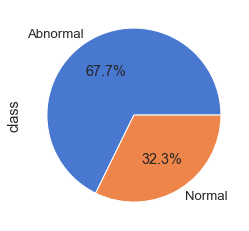

In [25]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set(font_scale=1.2, palette="muted")
data['class'].value_counts().plot.pie(autopct='%1.1f%%')

#### Violin plot displays SD, Mean, and IQR.  "Degree" has an extreme IQR and potential oulier's.

<AxesSubplot:>

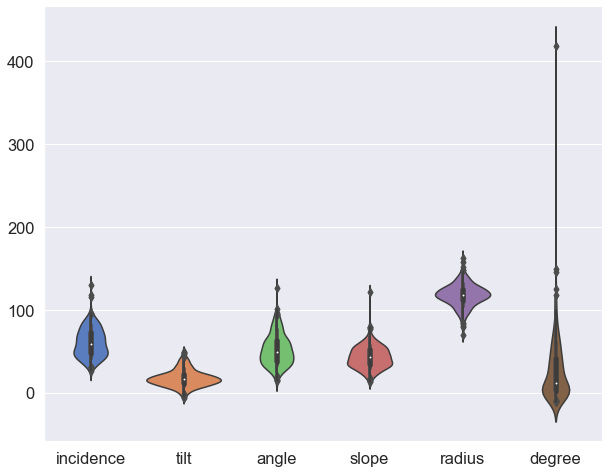

In [26]:
# Quick look at data shows strong possibility for outlier's in "Degree"
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5, palette="muted")
ax = sns.violinplot(data=data,whis=2.5)
sns.boxenplot(data=data, color="red", width=0.04)

The plot below shows mostly normal distribution of features, however, because of the skewed "degree" distribution, I don't feel an IQR test is best for determining outliers.  Z-test with a threshold of 3 will be used instead.

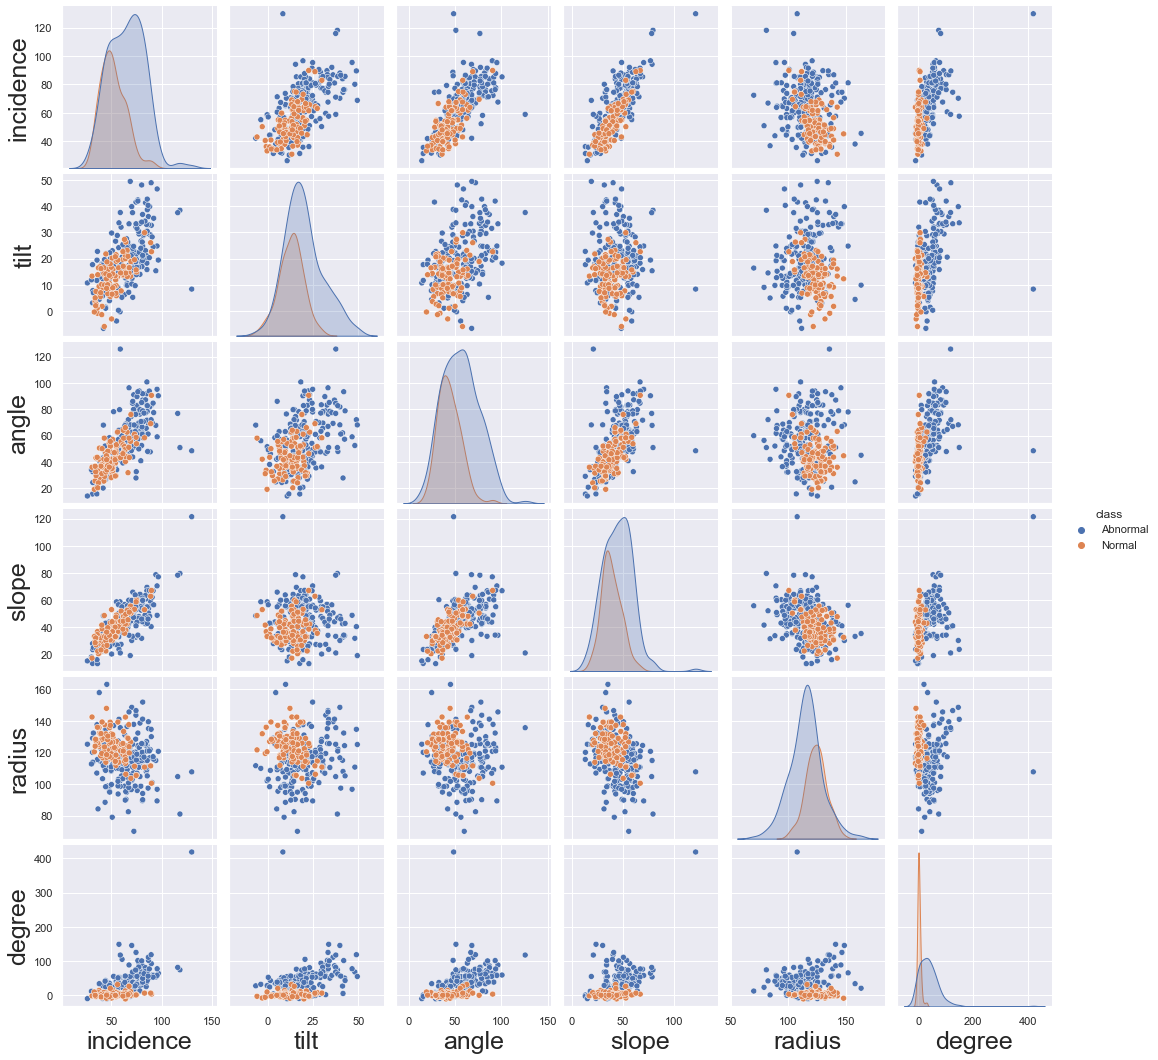

In [27]:
sns.set(rc={'figure.figsize':(8,7),"axes.labelsize":25})
sns.pairplot(data, hue="class")       # "Class" only correlations
plt.show()

#### We see 2 important things.  1) the data is imbalanced and will need addressing when building models through strastified train-test split and resampling during parameter tuning.  2) There appears to be an outlier that is clear in the "degree" feature and appears it could be across other features such as "slope" and "angle" as well.

#### Identify suspected Outlier's using Tukey's method for "degree"

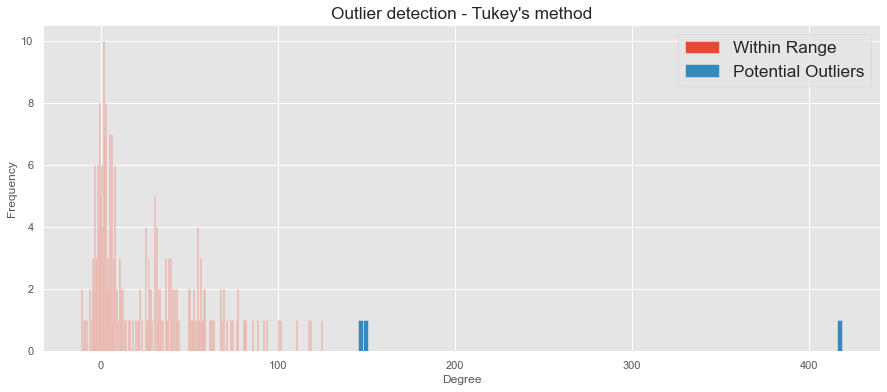

In [28]:
# Function detects potential outliers with Turkey's method comparing the z-score against a preset threshold

def tukey_outliers(data) -> list:
    plt.style.use('ggplot')
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if abs(z_score) > threshold:
            outliers.append(i)
    return outliers
spond_outliers = tukey_outliers(data['degree'])

plt.figure(figsize=(15,6))
data['degree'].plot(kind='hist', bins=1000, label='Within Range')
plt.hist(spond_outliers, bins = 100, label='Potential Outliers')
plt.title("Outlier detection - Tukey's method", fontsize='xx-large')
plt.xlabel('Degree')
plt.legend(fontsize='xx-large')

#### The degree = 420 was identified to be an outlier and removed.

In [29]:
data_orig = data.copy(deep=True)
data = data.loc[data['degree'] <= 200]     # Remove the oulier, values > 360

#### Review results of outlier removal

<AxesSubplot:>

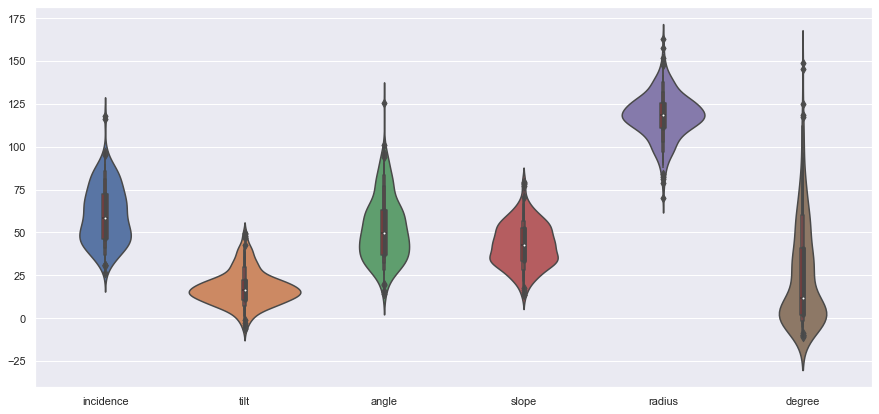

In [30]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.violinplot(data=data, whis=2.5)   # Review after removal
sns.boxenplot(data=data, color="red", width=0.04)

<AxesSubplot:>

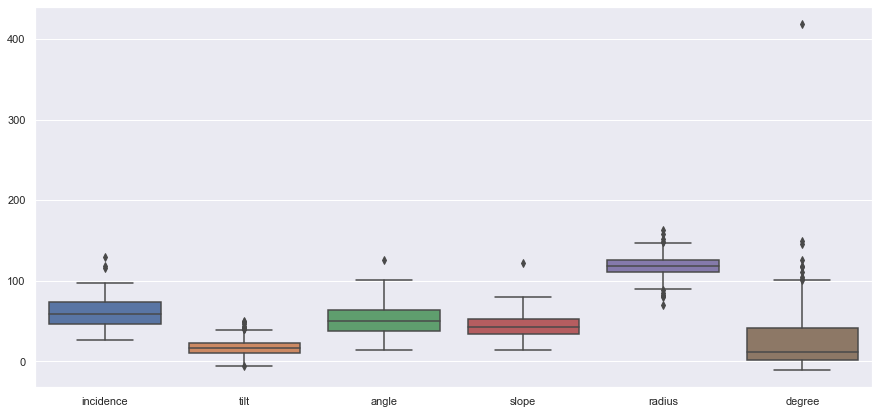

In [31]:
features = data_orig.drop(['class'],axis=1).copy(deep=True)
sns.boxplot(data=features)

<AxesSubplot:>

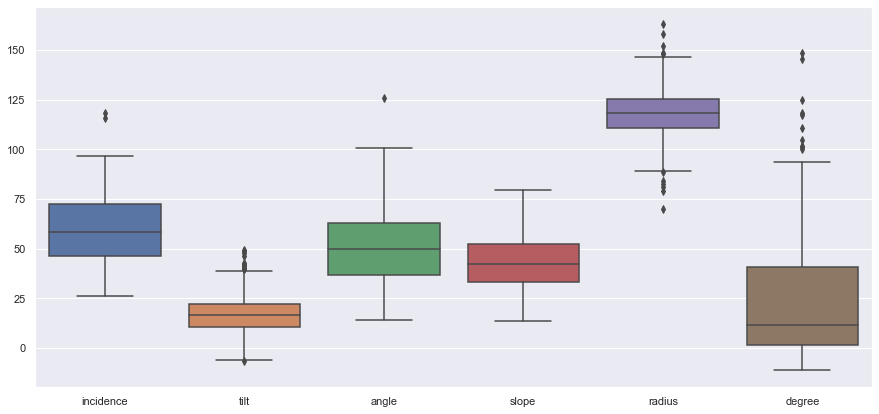

In [11]:
features = data.drop(['class'],axis=1).copy(deep=True)
sns.boxplot(data=features)

#### There are no data points > 2x distance from neighboring values.  For this project the remaining potential outlier's are accepted as valid.  The remaining data distrution is shown in the following pie chart.

<AxesSubplot:ylabel='class'>

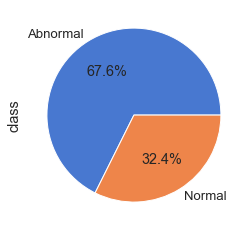

In [12]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set(font_scale=1.2, palette="muted")
data['class'].value_counts().plot.pie(autopct='%1.1f%%')

#### Encode Target as boolean

In [13]:
import warnings
warnings.filterwarnings(action='ignore')
label_encoder = LabelEncoder()                            # construct encoder
data.iloc[:,6] = label_encoder.fit_transform(data.iloc[:,6])  # encode
data.iloc[:,6] = np.ravel(data.iloc[:,6])                     # reshape


#### Create Feature & Target Variables

In [14]:
X = data.drop(['class'],axis=1).copy(deep=True)             # create predictor variable (features)
Y = data[['class']]                                         # Create Target variable

### Correlations

#### Below, Pearson's correlation map, shows the highest correlation between features is 853% for "slope" and "incidence".  Due to the importance of each feature's contribution in classification any features with <90% correlation were selected for modeling.  All features passed this boundry limit and hypothesis testing was performed to validate correlations exist between features and their target.

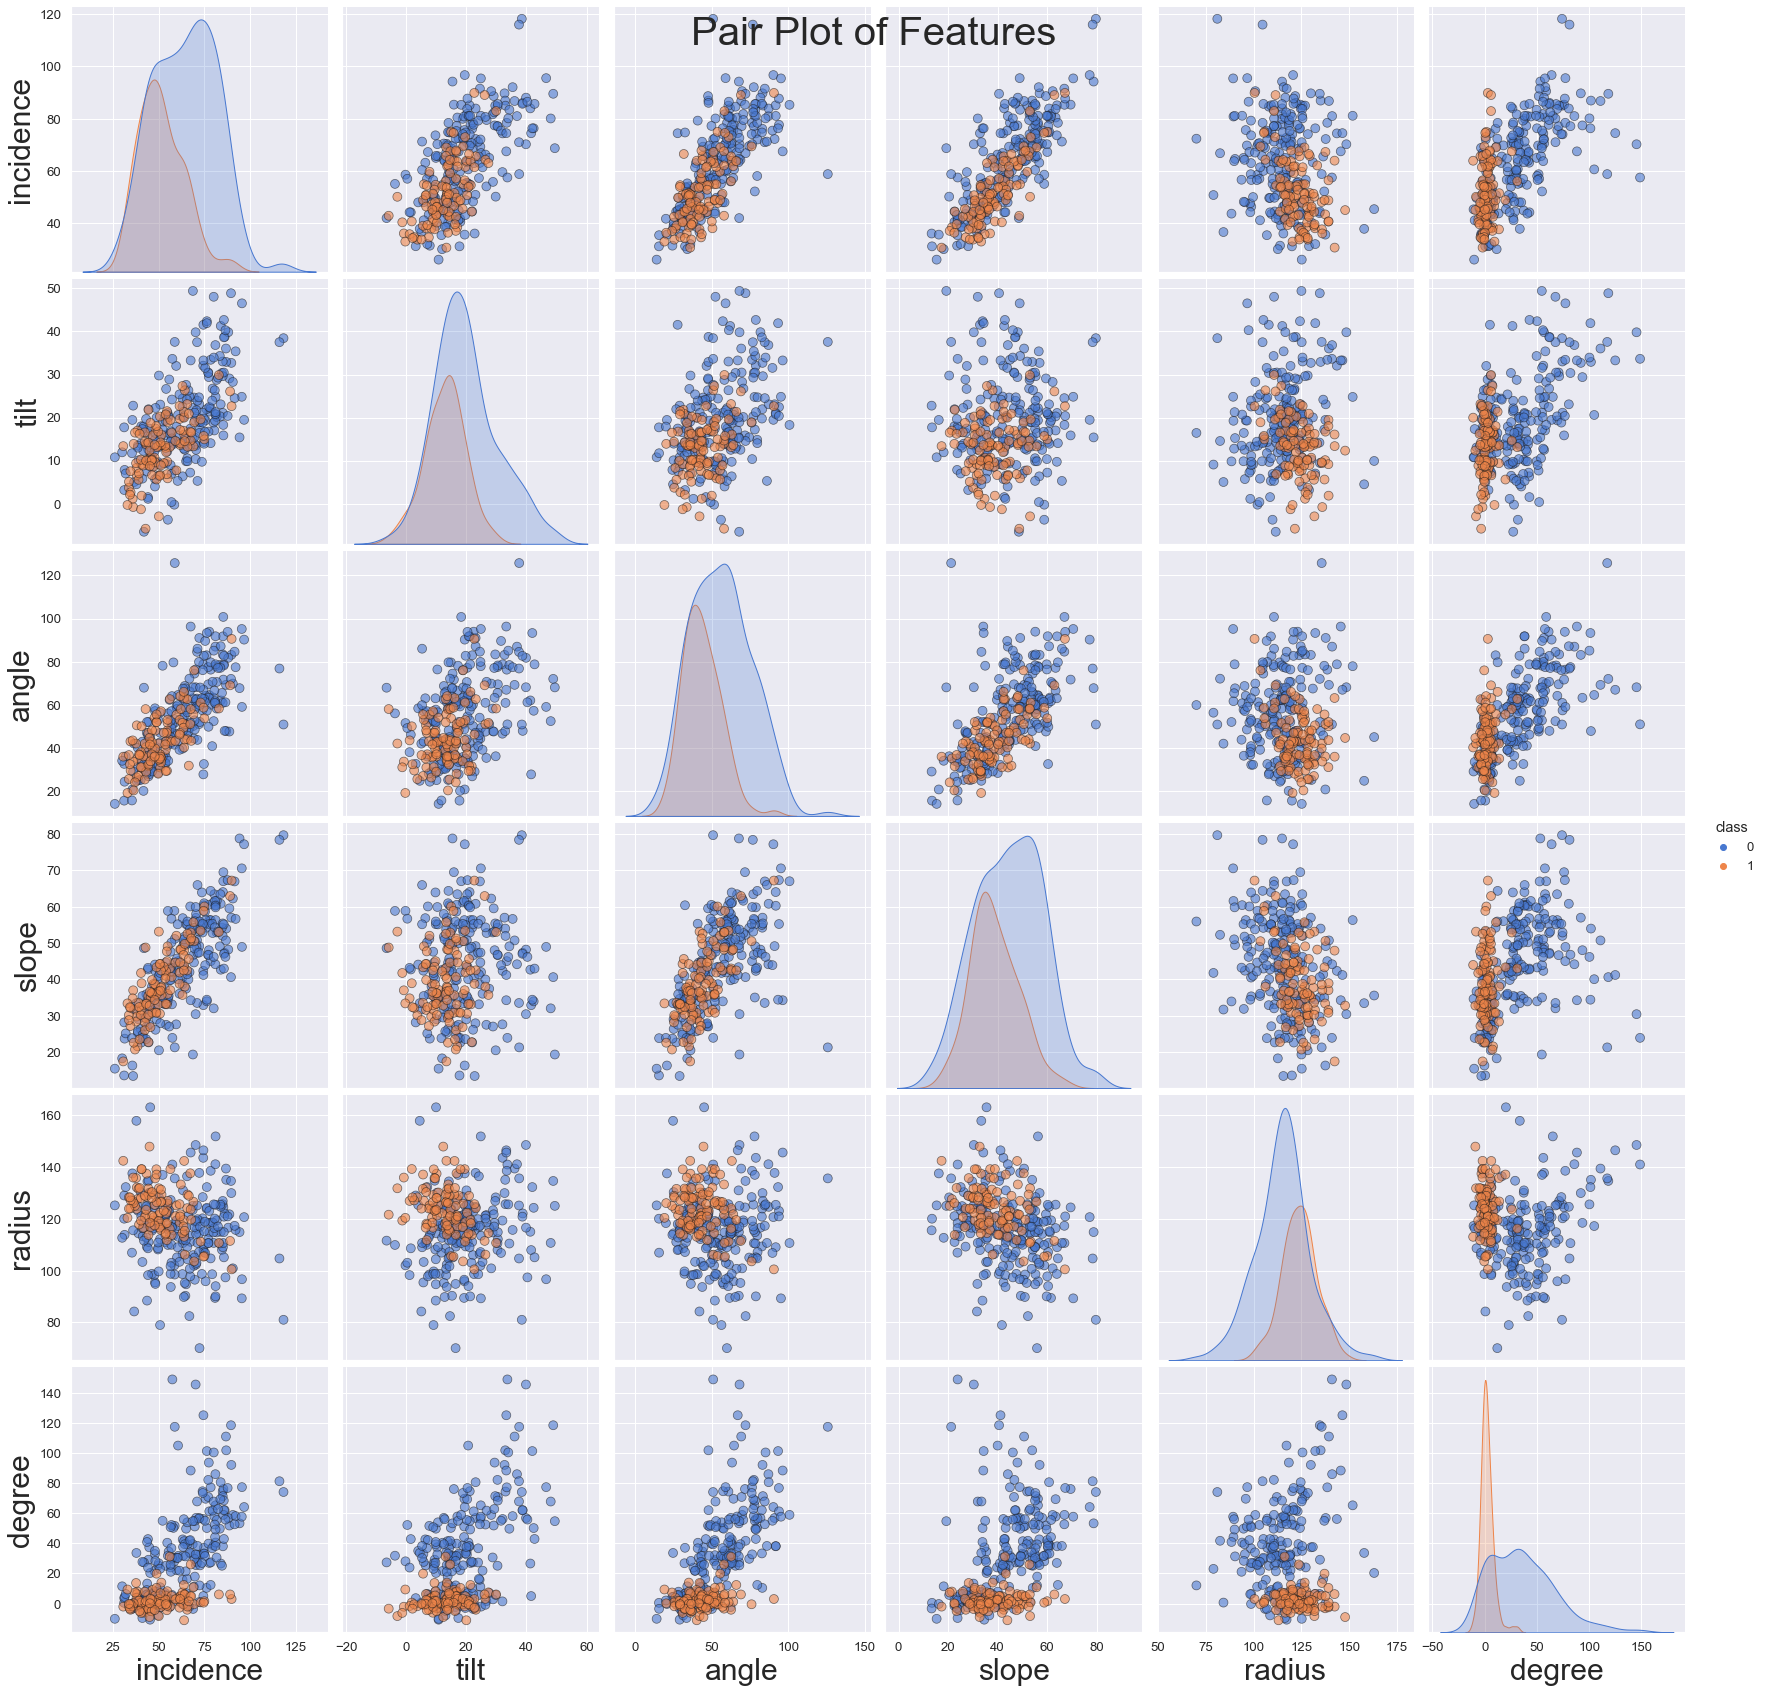

In [15]:
# Plot colored by continent for years 2000-2007
plt.rcParams["axes.labelsize"] = 30
sns.pairplot(data, 
             vars = ['incidence', 'tilt', 'angle', 'slope', 'radius','degree'], 
             hue = 'class', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4);
# Title

plt.suptitle('Pair Plot of Features', 
             size = 40);

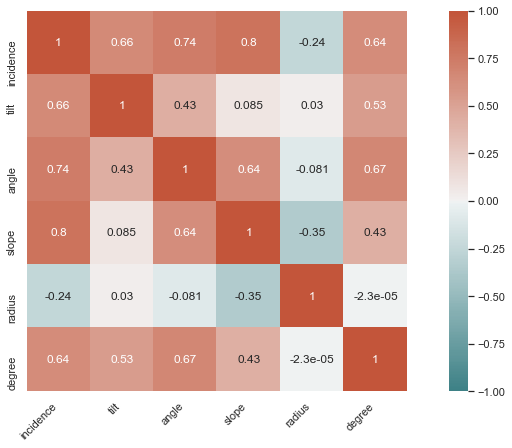

In [34]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(200, 20, n=500),
    square=True,annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

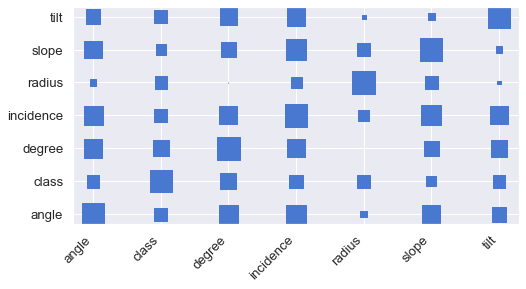

In [17]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
corr = data.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

Text(0.5, 1.0, 'Pearson Correlation Map')

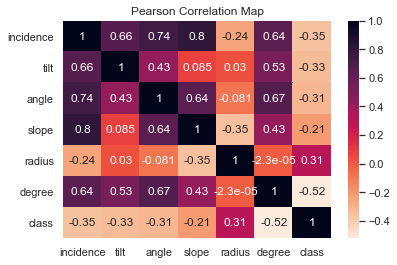

In [18]:
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(data.corr(), cmap="rocket_r", annot=True)
plt.title("Pearson Correlation Map")

### Hypothesis Testing to determine viability of features used in model
#### H0: there does not exist a statistically significant difference between normal and abnormal within each feature, therefore the feature has no correlation to the resulting target.

#### Below we see the data is normally distributed - qualifies for t-test

Text(0.5, 1.02, 'Distribution of Features')

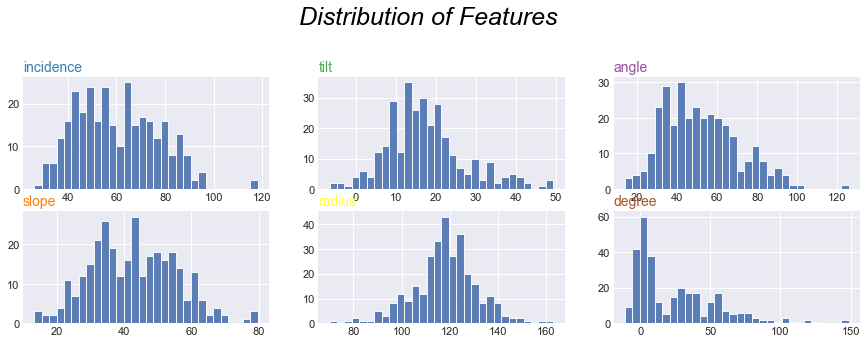

In [16]:
#                                  PLOT DATA DISTRIBUTION OF ALL FEATURES
sns.set(rc={'figure.figsize':(15,7)})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0
for column in X:
    num+=1
    plt.subplot(3,3, num)
    plt.hist(X[column], bins=30, alpha=0.9, label=column)
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
    plt.title(column, loc='left', fontsize=14, fontweight=0, color=palette(num))
plt.suptitle("Distribution of Features", fontsize=25, fontweight=0, color='black', style='italic', y=1.02)

#### Perform student t-test on this normally distributed data with single target - all passed the alpha of <0.05% and the Null Hypothesis failed, validating the Abnormal/Normal data within each feature contains significant differences and therefore contribute to the target result.

In [17]:
#. create variable to hypothesis testing

normal_d = data.degree[data["class"] == 1]
abnormal_d = data.degree[data["class"] == 0]
normal_i = data.incidence[data["class"] == 1]
abnormal_i = data.incidence[data["class"] == 0]
normal_r = data.radius[data["class"] == 1]
abnormal_r = data.radius[data["class"] == 0]
normal_s = data.slope[data["class"] == 1]
abnormal_s = data.slope[data["class"] == 0]
normal_t = data.tilt[data["class"] == 1]
abnormal_t = data.tilt[data["class"] == 0]
normal_a = data.angle[data["class"] == 1]
abnormal_a = data.angle[data["class"] == 0]

In [18]:
# Perform student t-test used for hypothesis testing.

columns = ['incidence','angle','slope','degree','tilt','radius']
def test(r,t,name):
    a, b = stats.ttest_ind(r,t, equal_var = False)
    print("The p-value for",name,":  ",np.mean(b))
#        print("The ttest for ",name,": ",abs(np.mean(a)))
test(normal_d, abnormal_d, name="degree")
test(normal_i, abnormal_i, name="incidence")
test(normal_r, abnormal_r, name="radius")
test(normal_s, abnormal_s, name="slope")
test(normal_t, abnormal_t, name="tilt")
test(normal_a, abnormal_a, name="angle")

The p-value for  degree :   1.0866025811155934e-36
The p-value for  incidence :   1.720325765945183e-12
The p-value for  radius :   1.9625404743220364e-10
The p-value for  slope :   3.327823020643103e-05
The p-value for  tilt :   1.258928899255553e-11
The p-value for  angle :   8.335986160767663e-11


#### Store cleaned data variables for use in machine learning models

In [19]:
# DELIVERABLES - variables for use in models after cleaning and EDA

print(data['class'].value_counts())
print(data.nunique()) 

data.to_csv('Data/data.csv',index=False)  # Full dataset Encoded
X.to_csv('Data/X.csv',index=False)      # Feature set
Y.to_csv('Data/Y.csv',index=False)      # Target set

0    209
1    100
Name: class, dtype: int64
incidence    309
tilt         309
angle        279
slope        280
radius       309
degree       309
class          2
dtype: int64
